In this second practical session, we explore surface deformation algorithms with two applications : surface parametrization for texture mapping and as-rigid-as possible deformation for non-rigid alignment.

Program for today:
1. Surface Parameterisation

    a. Tutte embedding,

    b. Angle-preserving map with free boundary.
    
2. Surface alignment

    a. Rigid alignment with Iterative Closest Point,

    b. ARAP for non-rigid alignment.


# Environment Setup

You'll need to install meshplot, using either:
- Conda:
   - ```conda install -c conda-forge meshplot```
- Pip:
   - ```pip install pythreejs```
   - ```pip install git+https://github.com/skoch9/meshplot.git```

Works best with jupyter notebook.

In [163]:
import os
import shutil

import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sla
import scipy.sparse
from scipy.sparse import csc_matrix

# THE FOLLOWING COME FROM THE PROVIDED DATA, DO NOT TRY TO PIP INSTALL THEM
import plot_utils as plu
import mesh_utils
from mesh_utils.mesh import TriMesh

# Surface Parameterisation

Given a triangle mesh with triangle list $T$ ($n_f \times 3$ array of integers) and vertex coordinates $X$ ($n_v \times 3$ array of floats), a parametrization is simply an assignment of planar coordinates $U$ ($n_v \times 2$ array of floats) for each vertex of the mesh. This parametrization will be vizualized by mapping a texture in planar coordinates to 3D coordinates.

## Tutte embedding

The most simple way of computing planar coordinates is to fix the boundary of the mesh to predefined positions (in this example a unit circle) and place the inner vertices at the barycenter of their neighbours. For a boundary vertex $j$, the coordinates $(u_j,v_j)$ are constrained to the position $(\bar{u}_j,\bar{v}_j)$. More precisely, the planar coordinates $(u_i,v_i)$ of vertex $i$ satisfies the system of equations:
\begin{array}{lll}
    \sum_{j \in N_i} w_{ij} (u_j - u_i) = 0, & \sum_{j \in N_i} w_{ij} (v_j - v_i) = 0, & \text{ for all boundary vertices } i, \\
    u_j = \bar{u}_j, & u_j = \bar{v}_j, & \text{ for all interior vertices } j,
\end{array}
where $w_{ij}$ are the cotan-weights computed in the previous practical session and $N_i$ is the set of vertices linked to $i$ by an edge.

This system of linear equations can be easily rewritten in term of Laplacian matrix $W$ computed in the previous session:
$$
\begin{array}{l}
(W u)_i = 0, \text{ and } (W v)_i = 0  \text{ for all interior vertices $i$,} \\
u_j = \bar{u}_j, \text{ and } v_j = \bar{v}_j \text{ for all boundary vertices $j$.}
\end{array}
$$

Let `id_int` and `id_bnd` be the lists of interior and boundary indices. The boundary coordinates `u[id_bnd]` and `v[id_bnd]` are coordinates evenly distributed on a circle.  With the boundary coordinates `u[id_bnd]` given, we want to solve the system of linear equations `W[id_int,:][:,id_int]*u[id_int] =-W[id_int,:][:,id_bnd]*u[id_bnd]` for the variables `u[id_int]`.

This is done in three steps:
1. Build the lists `id_int` and `id_bnd`
2. Solve the constrained system of linear equations
3. Vizualize the texture

###  QUESTION 1 - Border Edges

**Given a set of triangles, compute the list of (unordered) edges which lie at the border**

In [164]:
def get_border_edges(triangles):
    """
    Get the border edges of a mesh. In no particular order

    Parameters
    ----------
    triangles : ndarray of shape (n_triangles, 3)

    Returns
    -------
    border_edges : list of list of length n_border_edges.
                   The border edges of the mesh. Element i contains the two
                     vertices of the i-th border edge. 
    """
    # YOUR CODE HERE    
    edge_count = {}
    
    # Count occurrences of each edge
    for triangle in triangles:
        for i in range(3):
            edge = tuple(sorted([triangle[i], triangle[(i+1)%3]]))
            edge_count[edge] = edge_count.get(edge, 0) + 1
            
    # Collect edges that appear only once: that lie at the border
    border_edges = [list(edge) for edge, count in edge_count.items() if count == 1]
    border_edges = np.array(border_edges)
    
    return border_edges

In [165]:
mesh1 = TriMesh('./data/sphere_cut_uv.obj').process(k=0)
border_edges = get_border_edges(mesh1.faces)
# Visualize the border. It is here just a cut of the sphere
plu.plot(mesh1, points=np.unique(border_edges))

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

### Question 2 - Orderd points on a circle

**Write a function to generate evenly spaced points on the circle in a counterclockwise order.**
These are going to be the fixed positions of our border vertices

In [166]:
def get_n_points_on_circle(n_points):
    """
    Builds n_points evenly spaced points on the unit circle.

    Parameters
    ----------
    n_points : int
        Number of points to generate

    Returns
    -------
    points : ndarray of shape (n_points, 2)
        The points on the unit circle
    """
    # YOUR CODE HERE
    points = [[np.cos(2*k*np.pi/n_points),np.sin(2*k*np.pi/n_points)] for k in range(n_points)]
    points = np.array(points)
    return points

(np.float64(-1.1),
 np.float64(1.1),
 np.float64(-1.046162167924669),
 np.float64(1.046162167924669))

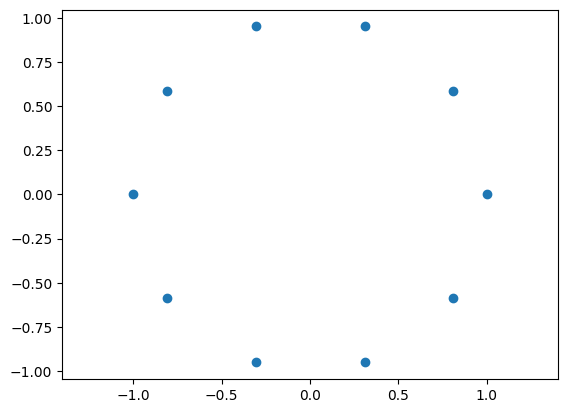

In [167]:
#Check for possible duplicate points!
circle_points = get_n_points_on_circle(10)
plt.figure(dpi=100)
plt.scatter(circle_points[:,0], circle_points[:,1])
plt.axis('equal')

### Question 3 - Solving the Embedding

**Solve for the uv coordinate using ```scipy.sparse.linalg.spsolve```**

Tip: The slicing ```W[id_int,id_int]``` does not work on a scipy sparse matrix, instead use ```W[id_int,:][:,id_int]```.

Because the function `get_n_points_on_circle` gives an *ordered* set of points on the circle but the function `get_border_edges` outputs vertices which are *unordered*, we will need to *sort* the list of border edges. We provide the function ```build_ordered_edges``` below which generates an *ordered* list of border edges using the output of ```get_border_edges``` defined in Question 1.

In [168]:
def find_next_edge(current_edge, remaining_edges):
        for i, edge in enumerate(remaining_edges):
            if current_edge[1] in edge:
                return i, edge #if edge[0]==current_edge[1] else edge[::-1]
        return None, None

def build_ordered_edges(triangles):
    """
    Compute an ordered list of edges that form a path around the border of the mesh.

    Parameters
    ----------
    triangles : ndarray of shape (n_triangles, 3)

    Returns
    -------
    ordered_edge_list : list of list of length n_border_edges.
                        The border edges of the mesh. Element i contains the two
                        vertices of the i-th border edge.
    """
    
    border_edges = get_border_edges(triangles)  # (p,2)
    #a supprimer
    #print(len(border_edges))
    #border_edges = copy.deepcopy(unique_edges)
    remaining_edges = border_edges.copy().tolist()
    
    ordered_edge_list = []
    
    current_edge = remaining_edges[0]
    ordered_edge_list.append(current_edge)
    
    remaining_edges.pop(0)
        
    while remaining_edges:
        
        i_edge, next_edge = find_next_edge(current_edge, remaining_edges)
        #print(len(remaining_edges), i_edge, next_edge, current_edge)
        if next_edge:
            # Add the next edge to the ordered list
            #print("toadd:",  next_edge if next_edge[0]==current_edge[1] else [next_edge[1], next_edge[0]])
            ordered_edge_list.append(next_edge if next_edge[0]==current_edge[1] else [next_edge[1], next_edge[0]])

            # Remove the next edge from the list of border edges
            remaining_edges.pop(i_edge)

            # Update the current edge for the next iteration
            current_edge = ordered_edge_list[-1]
        else:
            # If no next edge is found, break the loop
            break
    return ordered_edge_list     

In [169]:
# Load the mesh and compute the Laplacian
mesh1 = TriMesh('./data/sphere_cut_uv.obj').process(k=0)

In [170]:
#TODO Compute the embedding u,v using the text above.
# Get the list of ordered edges and the Laplacian
import copy 
ordered_edges = build_ordered_edges(mesh1.faces)

#
#Insert below cell
#
def unique_values_in_order(arr):
    unique_values = []
    for sublist in arr:
        for value in sublist:
            if value not in unique_values:
                unique_values.append(value)
    return unique_values
    
#First step build the lists id_int and id_bnd
id_all = unique_values_in_order(mesh1.faces)
id_bnd = unique_values_in_order(ordered_edges)
id_int = [i for i in range(len(id_all)) if i not in id_bnd]


#Second Step : Solve the constrained 
coord_bnd = get_n_points_on_circle(len(id_bnd)) #coordinates (u,v) of the vertices at the boundary

u = np.zeros((len(id_all), 1))      #initialization of the vectors u and v
v = np.zeros((len(id_all), 1))

for k in range(len(id_bnd)):        #fill the values in u and v for the boundary vertices 
    u[id_bnd[k]] = coord_bnd[k,0]          
    v[id_bnd[k]] = coord_bnd[k,1]
    
W = mesh1.W  #get the W matrix from the TriMesh class

#solve the constrained system of linear equation
print(scipy.sparse.linalg.spsolve(W[id_int,:][:,id_int], -W[id_int,:][:,id_bnd]*u[id_bnd]).shape)
u[id_int] = scipy.sparse.linalg.spsolve(W[id_int,:][:,id_int], -W[id_int,:][:,id_bnd]*u[id_bnd]).reshape(len(id_int),1)
v[id_int] = scipy.sparse.linalg.spsolve(W[id_int,:][:,id_int], -W[id_int,:][:,id_bnd]*v[id_bnd]).reshape(len(id_int),1)
    
uv_total =  np.hstack((u, v))  ### (n,2) computed UV coordinates (takes more than 1 line)
print(uv_total.shape)

flat_coords =  np.zeros((mesh1.n_vertices,3))
flat_coords[:,:2] = uv_total

(2513,)
(2609, 2)


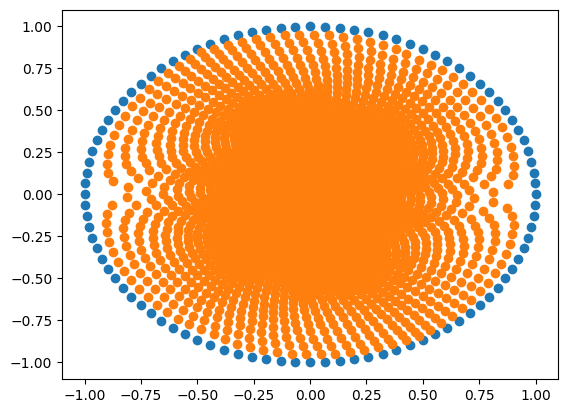

In [171]:
# Check that the constraints are good (normally naturally, since you built the system accordingly
plt.scatter(flat_coords[id_bnd][:, 0], flat_coords[id_bnd][:, 1])
plt.scatter(flat_coords[id_int, 0], flat_coords[id_int, 1])

In [172]:
# Visualize the texture on the mesh
uv_map = mesh_utils.read_obj_texture('./data/sphere_cut_uv.obj')[-1]

plu.plot_textured_mesh(mesh1, uv_map, points=np.unique(border_edges.flatten()), wireframe=True)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

In [173]:
# Visualize the results

# Flattened coordinates with reegular grid
plu.plot_texture(flat_coords, mesh1.faces, uv_total, wireframe=True) 

# We can take the regular grid back to the sphere
plu.plot_texture(mesh1.vertices, mesh1.faces, uv_map, wireframe=True)

# Or take the Texture of the sphere to the flat world
plu.plot_texture(flat_coords, mesh1.faces, uv_total, wireframe=True)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

Let's now visualize how it would render on the Earth

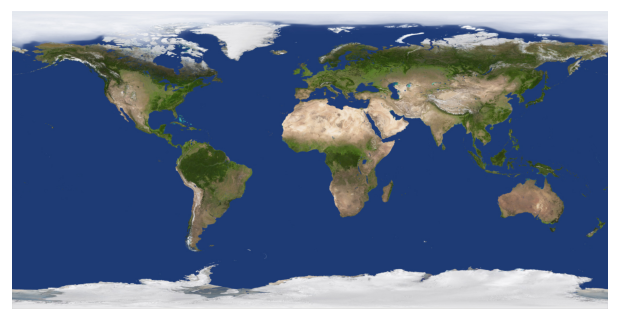

In [174]:
image = plt.imread('data/earth_daymap.jpg')
plt.figure(dpi=120)
plt.imshow(image)
plt.axis('off');

In [175]:
os.makedirs('results', exist_ok=True)
shutil.copyfile('data/earth_daymap.jpg', 'results/earth_daymap.jpg')


# THIS EXPORTS A .OBJ FILE WITH TEXTURE AND MATERIAL INFORMATION. DOWNLOAD AND OPEN WITH MESHLAB
TriMesh(mesh1.vertices, mesh1.faces).export_texture('results/tutte_earth.obj', uv_map, texture_im='earth_daymap.jpg')
TriMesh(flat_coords, mesh1.faces).export_texture('results/tutte_earth_flat.obj', uv_map, texture_im='earth_daymap.jpg')

## Least Square Conformal Map

Conformal maps are special type of parametrizations which preserve angles. On a smooth surface, they are characterized by the relationship between the gradient of the coordinate $u$ and the coordinate $v$
$$ \nabla u = n \times \nabla v $$
where $n$ is the surface normal. On a triangle mesh, the coordinates $(u,v)$ are computed using a linear least-squares problem
$$ \min_{u,v} \sum_{t \in T} A_t |\nabla u - n \times \nabla v|^2 \text{ subject to the constraint: } \sum_i u_i^2 + v_i^2 = 1 $$
where $A_t$ is the area of triangle $t$. As explained in the course, the objective function can be written in term of the Laplacian matrix $W$. This leads to the smallest eigenvalue problem
$$ \min_{u,v} \begin{pmatrix} u \\ v \end{pmatrix}^\top \begin{pmatrix} W & -M \\ -M^\top & W \end{pmatrix} \begin{pmatrix} u \\ v \end{pmatrix} \text{ subject to the constraint: } \sum_i u_i^2 + v_i^2 = 1 $$
The sparse matrix $M$ of size $n_v \times n_v$ is given by
$$ M_{ij} = \left\lbrace \begin{array}{ll} 
0 & \text{if $i$ or $j$ is an interior vertex } \\
1/2 & \text{if $i$ to $j$ is a positive edge of the boundary triangle} \\
-1/2 & \text{if $i$ to $j$ is a negative edge of the boundary triangle} 
\end{array} \right.$$

Positive edges are edges that appear when going around a face in the order provided in the file. Negative edges are when going the opposite direction.

*Tips:* To assemble this matrix simply accumulate $\pm\frac{1}{2}$ values for all triangles using the triangle list using the formula above. Since interior edges appear twice in opposite direction in the mesh, their coefficient will vanish for them, and only values for border edges will remain.


1. Build the sparse matrix `M`
2. Compute the LSCM parametrization using `scipy.sparse.linalg.eigs` 
3. Extract the boundary coordinate of the parametrization and use them to compute a Tutte embedding 

### Question 4 - Build M

In [176]:
def get_unique_values(array):
    # Flatten the 2D array and convert to a set (with unique values, no repetition)
    unique_values = set(value for sublist in array for value in sublist)
    return unique_values

In [177]:
def build_M(faces):
    """
    Build the M matrix above with values only at border edges.
    M can be build by adding the formula for M_ij for each edge of each face on the mesh.
    Coefficients at interior edges will vanish because they appear twice with opposite signs.

    Parameters
    ----------
    faces : ndarray of shape (n_faces, 3)

    Returns
    -------
    M : scipy.sparse.csr_matrix of shape (n_vertices, n_vertices)
    """    
    vertices = get_unique_values(faces)
    M = np.zeros((len(vertices), len(vertices)))
    
    for i in range(len(faces)):
        [indice1, indice2, indice3] = faces[i]
        M[indice1, indice2] += 1/2
        M[indice1, indice3] -= 1/2
        M[indice2, indice3] += 1/2
        M[indice2, indice1] -= 1/2
        M[indice3, indice1] += 1/2
        M[indice3, indice2] -= 1/2
            
    I = []
    J = []
    V = []
    for i in range(len(vertices)):
        for j in range(len(vertices)):
            if M[i, j] != 0:
                I.append(i)
                J.append(j)
                V.append(M[i, j])
                                
    M = scipy.sparse.csr_matrix((V, (I, J)), shape=(len(vertices), len(vertices)))
    
    return M

In [178]:
M = build_M(mesh1.faces)
print(M.data) #only 1/2 and -1/2 values it seems ok

[-0.5  0.5  0.5 -0.5 -0.5  0.5 -0.5  0.5  0.5 -0.5 -0.5  0.5  0.5 -0.5
  0.5 -0.5 -0.5  0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5
  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5
  0.5 -0.5  0.5 -0.5  0.5 -0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5
 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5
 -0.5  0.5 -0.5  0.5  0.5 -0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5
 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5
 -0.5  0.5 -0.5  0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5
  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5
  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5 -0.5  0.5 -0.5  0.5
 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5
 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5  0.5 -0.5 -0.5  0.5 -0.5  0.5
 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5
 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5  0.5 -0.5]


### Question 5 - Solve the system

Use scipy [bmat function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.bmat.html) to build sparse matrices from blocks.

Try with the two meshes (diablo doesn't have uv map)

In [179]:
#mesh1 = TriMesh("./data/diablo_cut2.obj").process(k=0)
mesh1 = TriMesh("./data/sphere_cut_uv.obj").process(k=0)
v,f,uv_map = mesh_utils.read_obj_texture('./data/sphere_cut_uv.obj')
W = mesh1.W

$$ \min_{u,v} \begin{pmatrix} u \\ v \end{pmatrix}^\top \begin{pmatrix} W & -M \\ -M^\top & W \end{pmatrix} \begin{pmatrix} u \\ v \end{pmatrix} \text{ subject to the constraint: } \sum_i u_i^2 + v_i^2 = 1 $$
is equivalent to the following eigenvalue problem : 
$$\begin{pmatrix} W & -M \\ -M^\top & W \end{pmatrix} \begin{pmatrix} u \\ v \end{pmatrix} = \lambda \begin{pmatrix} A & 0 \\ 0 & A \end{pmatrix} \begin{pmatrix} u \\ v \end{pmatrix}$$
where $A$ is the Area matrix

In [180]:
M = build_M(mesh1.faces)
#TODO
system_matrix = scipy.sparse.bmat([[W, -M], [-M.T, W]]) 
M_matrix_generalized_eigen_problem = scipy.sparse.bmat([[mesh1.A, None], [None, mesh1.A]])

res_eigenvalues, res_eigenvectors = scipy.sparse.linalg.eigsh(system_matrix, k=3, M = M_matrix_generalized_eigen_problem, which='LM', sigma=-0.001)

# Check that first 2 eigenvalues are 0
print(res_eigenvalues)

[-1.34939802e-15 -1.04408669e-15  2.90318160e-03]


We consider the 2 first eigenvalue as 0 : ok

In [181]:
uv_coords = res_eigenvectors[:,2].reshape((mesh1.n_vertices,2), order='F')

plu.plot_texture(mesh1.vertices, mesh1.faces, uv_coords)
flat_coords =  np.zeros((mesh1.n_vertices,3))
flat_coords[:,:2] = uv_coords
plu.plot_texture(flat_coords, mesh1.faces, uv_map, wireframe=True) 


# For the Sphere
#plu.plot_texture(flat_coords, mesh1.faces, uv_map, wireframe=True)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-3.179907…

you can again visualize with the earth map on the sphere

In [182]:
TriMesh(mesh1.vertices, mesh1.faces).export_texture('results/lscm_earth.obj', uv_map, texture_im='earth_daymap.jpg')
#TriMesh(flat_coords, mesh1.faces).export_texture('results/lscm_earth.obj', uv_map, texture_im='earth_daymap.jpg')

###  Question 6 - Extract the boundary of the U,V conformal coordinates and compute the tutte embedding on the same boundary

Tips: be careful with the ordering of the boundery vertices

In [183]:
flat_coords_bnd = flat_coords[id_bnd]

u2 = np.zeros((len(id_all), 1))      #initialization of the vectors u and v
v2 = np.zeros((len(id_all), 1))

for k in range(len(id_bnd)):        #fill the values in u and v for the boundary vertices 
    u2[id_bnd[k]] = flat_coords_bnd[k,0]          
    v2[id_bnd[k]] = flat_coords_bnd[k,1]
    
W = mesh1.W  #get the W matrix from the TriMesh class

#solve the constrained system of linear equation
u2[id_int] = scipy.sparse.linalg.spsolve(W[id_int,:][:,id_int], -W[id_int,:][:,id_bnd]*u2[id_bnd]).reshape(len(id_int),1)
v2[id_int] = scipy.sparse.linalg.spsolve(W[id_int,:][:,id_int], -W[id_int,:][:,id_bnd]*v2[id_bnd]).reshape(len(id_int),1)
    
uv_total2 =  np.hstack((u2, v2))  ### (n,2) computed UV coordinates (takes more than 1 line)
print(uv_total2.shape)

flat_coords2 =  np.zeros((mesh1.n_vertices,3))
flat_coords2[:,:2] = uv_total2

(2609, 2)


In [184]:
plu.plot_texture(flat_coords2, mesh1.faces, uv_map, wireframe=True) 

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-3.179907…

# 2 Surface Alignment

## Iterative Closest Point

The goal of this algorithm is to align two point clouds $X = \{ x_i \}$ and $Y = \{ y_i \}$ using only rigid transformations -- translation and rotation. It is standard algorithm to align 3D scans taken from different viewpoints. The most basic implementation iterates between three steps until convergence:

1. For each point of $X$ compute the closest point in the set $Y$. This assignment is given by the table $p$
$$ p_i = \arg\min_{j} \|x_i - y_j\|^2 .$$
This can be done efficiently with a knn-search.

2. Find the translation that best align the point cloud given the assignment $p$
$$ \min_{t \in \mathbb{R}^3} \sum_i \|x_i + t - y_{p_i}\|^2 .$$
This problem can be solved exactly with the formula $t = \frac{1}{|X|}\sum_i y_{p_i} - x_i$.

3. Compute the rotation aligning the point cloud after translation:
$$ \min_{R} \sum_i \|Rx_i + t - y_{p_i}\|^2 .$$
This is an [orthogonal Procrustes problem](https://en.wikipedia.org/wiki/Orthogonal_Procrustes_problem) and can be solved efficiently using a Singular Value Decomposition ([SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition)). Let the matrix $A = \sum_i (t-y_{p_i})x_i^\top$ be decomposed as $A = U S V^\top$ where $U,V$ are unitary matrices and $S$ a diagonal matrix. The optimal rotation is given by $R = U D V^\top$ with $D$ a diagonal matrix with $+1$ on the diagonal corresponding to the two largest singular values and $\pm 1$ on the smallest singular value. The sign is chosen so that $\det R = 1$.

4. Update the position of $X$: $x_i \leftarrow Rx_i+t$


**To do:**
1. Implement the steps
2. Align the Armadilo

### Question 7 - Compute Nearest Neighbor

In [185]:
def compute_nearest_neighbor(X, Y):
    """
    Compute the nearest neighbor in Y for each point in X

    Parameters:
    -----------
    X : (n, d) array of points
    Y : (m, d) array of points

    Returns:
    --------
    nearst_neighbor : (n,) array of indices of the nearest neighbor in Y for X
    """
    # TODO DO NOT USE LOOPS
    # Compute pairwise squared Euclidean distances
    distances = np.sum((X[:, np.newaxis, :] - Y[np.newaxis, :, :]) ** 2, axis=2)

    # Find the index of the minimum distance for each point in X
    nearest_neighbor = np.argmin(distances, axis=1)

    return nearest_neighbor

### Question 8 - Compute optimal rotations and translation

In [186]:
def compute_rigid_transform(X_source, X_target):
    """
    Compute the optimal rotation matrix and translation that aligns two point clouds of the same size X_source and X_target.
    This rotation should be applied to X_source.

    Parameters:
    -----------
    X_source : (n, d) array of points
    X_target : (n, d) array of points

    Returns:
    --------
    R : (d, d) rotation matrix
    t : (d,) translation vector
    """
    # TODO
    p = compute_nearest_neighbor(X_source, X_target)

    t = np.mean(X_target[p] - X_source, axis=0)
    
    A = (t - X_target[p]).T @ X_source  
    
    U, S, V = scipy.linalg.svd(-A)   #it should be -A instead of A as said above
    D = np.eye(len(S))
        
    R = U@D@V
    
    return R, t

### Question 9 - Apply the ICP algorithm
We provide a function to apply a rigid transformation ```R,t``` to a point cloud

In [187]:
def transform_pointcloud(X,R,t):
    """
    Transform a point cloud X by a rotation matrix R and a translation vector t.

    Parameters:
    -----------
    X : (n, d) array of points
    R : (d, d) rotation matrix
    t : (d,) translation vector

    Returns:
    --------
    X_transformed : (n, d) array of transformed points
    """
    return X @ R.T + t

In [188]:
def icp_align(X_source, Y_target, n_iter=10):
    """
    Align two point clouds X_source and Y_target using the ICP algorithm.

    Parameters:
    -----------
    X_source : (n, d) array of points
    Y_target : (m, d) array of points
    n_iter   : int - number of iterations of the ICP algorithm

    Returns:
    --------
    X_aligned : (n, d) array of aligned points
    """
    # TODO compute ICP alignement
    X = X_source
    for k in range(n_iter):
        R, t = compute_rigid_transform(X, Y_target)
        X = transform_pointcloud(X, R, t)
        
    X_aligned = X
    return X_aligned

In [189]:
def plot_superimposed(mesh1, mesh2, *args, **kwargs):
    """
    Plot the superposition of the two meshes
    """
    mesh = TriMesh(np.concatenate([mesh1.vertices, mesh2.vertices], axis=0),
                   np.concatenate([mesh1.faces, mesh2.faces+mesh1.n_vertices], axis=0))
    plu.plot(mesh, *args, **kwargs)

mesh1 = TriMesh("./data/Armadillo_1.off")
mesh2 = TriMesh("./data/Armadillo_2.off")

plot_superimposed(mesh1, mesh2)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.5006730…

In [190]:
# VISUALIZE ICP Result, you can change the n_iter to improve results
vert1_aligned = icp_align(mesh1.vertices, mesh2.vertices, n_iter=200)  

plot_superimposed(TriMesh(vert1_aligned, mesh1.faces), mesh2)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.5286072…

## As-rigid-as possible deformation

This model of deformation tries to preserves at best the shape features. As explained in the course, given a triangle mesh ($T$: triangle list, $X$: vertex positions) the goal is to find new vertex positions $Y = \{ y_i\}$ which are as-close-as possible to a local rotation of the initial position $X$. More precisely, we store a rotation matrix $R_i$ at each vertex $i$ and find the rotations $R$ and position $y$ minimizing
$$ \min_{y,R} \sum_{i} \sum_{j \in N_i} w_{ij} \| y_i - y_j - R_i (x_i - x_j) \|^2, \text{  $y$ subject to position constraint,}$$
with $w_{ij}$ the cotan-weight and $N_i$ the set of vertices adajcent to $i$.

To solve this problem, we iterate between solving for best the position and for rotations.

1. Finding the optimal position $y$ is simply a constrained Laplacian problem (just like the first question)
$$W y = b, \quad \text{where } b_i = \sum_{j \in N_i} \frac{w_{ij}}{2} (R_i+R_j) (x_i - x_j) \text{ for each vertex $i$}, $$
and $y$ is constrained at some given vertices.

2. Finding the optimal rotation $R_i$ amounts for solving an orthogonal Procrustes problem for each vertex $i$ where the matrix $B_i = \sum_{j \in N_i} w_{ij} (y_i - y_j) (x_i - x_j)^\top$ is decomposed via a SVD (see step 3 of previous question).


**To do:**
1. Open the file diablo.obj. Solve constrained Laplacian problem with vertex indices `id_lock = [1175, 762, 381, 2383, 1836]` displaced by a vector `[0,0,-0.5; 0,0,0.5; 0,0,-0.5; 0,0,0.5; 1.5,0,0]`
2. Add procrustes problem for each vertex
3. Add a closest point query at the beginning of the iteration. Chose randomly N points which will be constrained during the iteration.

We provide a function to compute a list of neighbors for each vertex

In [191]:
def get_per_vertex_neighbors(faces):
    """
    Compute per-vertex neighbors from a list of triangles

    Parameters:
    -----------
    faces : (n, 3) array of vertex indices for each triangle

    Returns:
    --------
    neighbors : list of lists of vertex indices
    """

    neighbors = [set() for _ in range(faces.max()+1)]
    for face in faces:
        neighbors[face[0]].add(face[1])
        neighbors[face[0]].add(face[2])

        neighbors[face[1]].add(face[0])
        neighbors[face[1]].add(face[2])

        neighbors[face[2]].add(face[0])
        neighbors[face[2]].add(face[1])

    return [list(n) for n in neighbors]

### Question 10 - Compute the matrix $B_i$

In [192]:
def get_arap_edge_covariance(x,y, cotan_matrix, per_vertex_neighbors):
    """
    Compute the covariance matrix of the edge between x and y. (Formula B_i)

    Parameters:
    -----------
    x : (n,3) array of coordinates of x
    y : (n,3) array of coordinates of y
    cotan_matrix : (n,n) cotan matrix of the mesh
    per_vertex_neighbors : (n,) list with list of neighbors of each vertex

    Returns:
    --------
    covariances : (n, 3, 3) covariance matrices of the edge between x and y
    """
    N = x.shape[0]
    covariances = np.zeros((N,3,3))

    # YOUR CODE HERE
    # You can do a loop or let scipy do the job for you (faster)
    for i in range(N):
        for j in per_vertex_neighbors[i]:
            covariances[i] -= cotan_matrix[i,j]*np.outer(y[i] - y[j], x[i] - x[j]) #it should be minus instead of plus
    
    return covariances

### Question 11 - Compute the rotation $R_i$ from $B_i$

In [193]:
def get_rot_from_covariances(covariances):
    """
    Compute optimal rotation matrix from edge covariance matrices, using SVD.

    Parameters:
    -----------
    covariances : (n, 3, 3) covariance matrices for each vertex

    Returns:
    --------
    rots : (n, 3, 3) rotation matrices for each vertex
    """
    rots = np.zeros_like(covariances)  # (n, 3, 3)
    
    #  YOUR CODE HERE
    # You can do a loop or let scipy do the job for you (faster)
    for i in range(covariances.shape[0]):
        U, S, V = np.linalg.svd(covariances[i])
        rots[i] = U @ V
    
    return rots

### Question 12 - Compute the vector $b$

In [194]:
def compute_ARAP_rotated_vert(vertices, rotations, cotan_matrix, per_vertex_neighbors):
    """
    Compute the right hand term of the ARAP linear system (formula b_i)

    Parameters:
    -----------
    vertices : (n, 3) array of vertices
    rotations : (n, 3, 3) array of rotation matrices
    cotan_matrix : (n,n) cotan matrix of the mesh
    per_vertex_neighbors : (n,) list with list of neighbors of each vertex

    Returns:
    --------
    b : (n, 3) right hand term of the ARAP linear system
    """
    b = np.zeros((vertices.shape[0], 3))
    
    # YOUR CODE HERE
    # You can do a loop or let scipy do the job for you (faster)
    for i in range(vertices.shape[0]):
        for j in per_vertex_neighbors[i]:
            b[i] -= (cotan_matrix[i,j]/2)*np.matmul(rotations[i] + rotations[j], vertices[i] - vertices[j]) #it should be minus instead of plus
    return b

### Question 13 - Apply ARAP Deformation.
Note that the linear system is constrained. Use the same trick as in Question 1 to handle

In [195]:
mesh3 = TriMesh("./data/diablo2.obj").process(k=0)

# THE ID OF THE LANDMARKS
id_lock = [1175, 762, 381, 2383, 1836]

# THE EXPECTED POSITIONS OF THE LANDMARKS AFTER OPTIMIZATION
disp = np.array([[0,0,-0.5], [0,0,0.5], [0,0,-0.5], [0,0,0.5], [.5,0.5,0]])
positions_target = mesh3.vertices[id_lock] + disp

In [196]:
# VISUALIZE THE LANDMARKS
plu.plot(mesh3,
         points=np.concatenate([mesh3.vertices[id_lock], positions_target]),
         cmap_p=np.tile(np.arange(len(id_lock)),2),
         shading_p=dict(point_size=0.3),
         colormap='jet')

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

In [197]:
vertex_neighbors = get_per_vertex_neighbors(mesh3.faces)

W = mesh3.W.copy()
print(W.shape, mesh3.n_vertices)
# Interior vertices
id_in = [i for i in range(mesh3.n_vertices) if i not in id_lock]

# Initial guess for the vertices
init_res = np.zeros_like(mesh3.vertices)
init_res[id_lock] = positions_target
init_res[id_in] = mesh3.vertices[id_in]

# ARAP Loop. You can try to increase the number of iterations and see the difference
for i in range(1):

    # Compute rotation matrices, covariances, b
    covariances = get_arap_edge_covariance(mesh3.vertices, init_res, W, vertex_neighbors)
    rotations = get_rot_from_covariances(covariances)
    b = compute_ARAP_rotated_vert(mesh3.vertices, rotations, W, vertex_neighbors)
    
    # Compute right hand term and left hand term of ARAP SYSTEM
    # Think about the constraint, go back to the text in part 1.1 to see how to build the constrained system
    lhs = W #TODO left hand side of the system
    rhs = b #TODO right hand side of the system

    
    res = scipy.sparse.linalg.spsolve(lhs[id_in,:][:,id_in], rhs[id_in] - lhs[id_in,:][:,id_lock] * init_res[id_lock])
    final_res = np.zeros_like(init_res)
    final_res[id_lock] = positions_target
    final_res[id_in] = res

(2507, 2507) 2507


In [198]:
new_mesh = TriMesh(final_res, mesh3.faces)
plot_superimposed(new_mesh, mesh3)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.1135356…

In [199]:
plu.plot(new_mesh)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.1135356…

In [200]:
plu.plot(new_mesh,
         points=np.concatenate([mesh3.vertices[id_lock], positions_target]),
         cmap_p=np.tile(np.arange(len(id_lock)),2),
         shading_p=dict(point_size=0.3),
         colormap='jet')

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.1135356…